n_subplots# interpret cell state

In [3]:
from pathlib import Path
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import seaborn as sns
import matplotlib as mpl
from tqdm import tqdm
import torch
mpl.rcParams['figure.dpi'] = 150

In [4]:
from torch.utils.data import DataLoader
from ruamel.yaml import YAML

In [5]:
# data_dir = Path('data/')
data_dir = Path('/cats/datastore/data/')

assert data_dir.exists()

In [6]:
%load_ext autoreload
%autoreload 2

# Load in all of the raw data (original)

In [7]:
# all_data
dynamic = xr.open_dataset(data_dir / "RUNOFF/ALL_dynamic_ds.nc")

# static_ds = xr.open_dataset(Path(f'data/features/static/data.nc'))
all_static = xr.open_dataset(data_dir / f'RUNOFF/interim/static/data.nc')
all_static['station_id'] = all_static['station_id'].astype(int)
static = all_static

dynamic['station_id'] = dynamic['station_id'].astype(int)

# Code

In [8]:
print([d.name for d in (data_dir / "runs/").iterdir()])
print([d.name for d in (data_dir / "runs/ealstm_less_vars_2004_1607_1334").glob("*")])

(data_dir / "runs/ealstm_less_vars_2004_1607_1334")
(data_dir / "runs/lstm_less_vars_2004_1507_1028")

['ealstm_less_vars_2004_1707_1424', 'lstm_less_vars_2004_1507_1028', 'train_data.h5', 'train_data_scaler.p', 'lstm_ALL_vars_2004_2210_1035', 'lstm_all_vars_1998_2008_2210_110347', 'lstm_all_vars_1998_2008_2210_110727', 'lstm_all_vars_1998_2008_nh_2310_101443', 'lstm_all_vars_1998_2008_nh_2310_142625', 'ensemble__', 'ensemble_EALSTM', 'ensemble_lstm10', 'ensemble', '0_ensemble_results']
[]


PosixPath('/cats/datastore/data/runs/lstm_less_vars_2004_1507_1028')

In [11]:
import sys
sys.path.insert(1, '/home/tommy/neuralhydrology')

from neuralhydrology.modelzoo.ealstm import EALSTM
from neuralhydrology.modelzoo.cudalstm import CudaLSTM
from neuralhydrology.datasetzoo.camelsgb import CamelsGB
from neuralhydrology.datautils.utils import load_basin_file
from neuralhydrology.utils.config import Config
from neuralhydrology.utils.errors import NoTrainDataError
from neuralhydrology.training.train import BaseTrainer

## Load in config file

In [14]:
run_dir = data_dir / "runs/ensemble_EALSTM/ealstm_ensemble6_nse_1998_2008_2910_030601"

# Config file
config_path = (run_dir / "config.yml") 
config = Config(config_path)

## Extra Processes

In [15]:
# Get the list of basins that we actually have results for
lstm_preds_df = pd.read_csv("/cats/datastore/data/runs/ensemble/data_ENS.csv").drop("Unnamed: 0", axis=1)
lstm_preds_df["time"] = pd.to_datetime(lstm_preds_df["time"])
lstm_preds = lstm_preds_df.set_index(["station_id", "time"]).to_xarray()

VALID_BASINS = (lstm_preds_df["station_id"].unique())

In [16]:
# read in the training data
ds = xr.open_dataset(data_dir / "RUNOFF/ALL_dynamic_ds.nc")
ds['station_id'] = ds['station_id'].astype(int)

all_static = xr.open_dataset(data_dir / f'RUNOFF/interim/static/data.nc')
all_static['station_id'] = all_static['station_id'].astype(int)
static = all_static

# Create Model Embeddings

In [18]:
(run_dir / "model_epoch030.pt")

PosixPath('/cats/datastore/data/runs/ensemble_EALSTM/ealstm_ensemble6_nse_1998_2008_2910_030601/model_epoch030.pt')

In [19]:
# torch.load(model_path, map_location="cpu")

In [23]:
# Initialize model
# EA LSTM
model = EALSTM(config)
model_path = run_dir / "model_epoch030.pt"
model.load_state_dict(torch.load(model_path, map_location="cpu"))

# LSTM
lstm_run_dir = data_dir / "runs/ensemble/lstm_ensemble6_nse_1998_2008_2710_171032"
cfg_lstm = Config(lstm_run_dir / "config.yml")
lstm_model = CudaLSTM(cfg_lstm)
# lstm_model.lstm = LSTM(25, 64)
lstm_model_path = lstm_run_dir / "model_epoch030.pt"
lstm_model.load_state_dict(torch.load(lstm_model_path, map_location="cpu"))

<All keys matched successfully>

# Get cell state over time

In [87]:
# scaler_file = config.train_dir / "train_data_scaler.p"
# scaler = pickle.load(scaler_file.open("rb"))

# try: 
#     globals()["data"]
# except KeyError:
#     # load data
#     data = CamelsGB(config, is_train=False, period="test", scaler=scaler)
    
# DataLoader(data, batch_size=config.batch_size, num_workers=0)

In [96]:
from neuralhydrology.modelzoo.basemodel import BaseModel
from neuralhydrology.evaluation import RegressionTester
from neuralhydrology.utils.errors import NoTrainDataError
from typing import Tuple
from collections import defaultdict


def get_states_from_forward(model: BaseModel, loader: DataLoader) -> Tuple[np.ndarray, np.ndarray]:
    all_hidden_states = []
    all_cell_states = []
    # For all the basin data in Loader
    for basin_data in loader:
        with torch.no_grad():
            predict = model.forward(basin_data)
            all_hidden_states.append(predict["h_n"].detach().numpy())
            all_cell_states.append(predict["c_n"].detach().numpy())

    basin_hidden_states = np.vstack(all_hidden_states)
    basin_cell_states = np.vstack(all_cell_states)
    
    return basin_hidden_states, basin_cell_states

In [105]:
Tester = RegressionTester(cfg=config, run_dir=run_dir, period="test", init_model=True)
all_basins = load_basin_file(Path(config.train_basin_file))

all_basin_data = defaultdict(dict)

# For each basin create a DataLoader
for ix, basin in enumerate(tqdm(all_basins)):
    try:
        ds = Tester._get_dataset(basin)
    except NoTrainDataError:
        print(f"{basin} Missing")
        continue

    loader = DataLoader(ds, batch_size=config.batch_size, num_workers=0)
    basin_hidden_states, basin_cell_states = get_states_from_forward(model, loader)
    all_basin_data[basin]["h_s"] = basin_hidden_states
    all_basin_data[basin]["c_s"] = basin_cell_states
    if ix == 2:
        break
        
        
print("****** DONE DONE DONE *******")

  0%|          | 2/669 [00:10<57:41,  5.19s/it]

****** DONE DONE DONE *******


In [ ]:
# MODEL_STATE_FILE = config_path.parents[0] / "MODEL_STATE.pkl"

# if not MODEL_STATE_FILE.exists():
#     # run the forward passes for each basin
#     pass
#     pickle.dump(all_basin_data, MODEL_STATE_FILE.open("wb"))
# else:
#     # LOAD MODEL HIDDEN AND CELL STATES
#     try:
#         all_basin_data = pickle.load(MODEL_STATE_FILE.open("rb"))
#     except EOFError:
#         print(f"Empty file: {MODEL_STATE_FILE}")
#         print("try: `MODEL_STATE_FILE.unlink()` (will delete the file and start again)")

In [520]:
# BIG NUMPY ARRAY

# CONVERT to one big array
all_cs_data = []
basins = [k for k in all_basin_data.keys()]
for basin in tqdm(basins):
    all_cs_data.append(all_basin_data[basin]["c_s"])

all_cs_data = np.stack(all_cs_data, axis=-1)

In [504]:
# fp = data_dir / "RUNOFF/all_cs_data.npy"
# if not fp.exists():
#     np.save(fp.open("wb"), all_cs_data)
# else:

#     all_cs_data = np.load(fp.open("rb"))

Object `np.save()` not found.


In [508]:
# CREATE TIME
times = lstm_preds.time
time_deltas = sorted(pd.to_timedelta(np.arange(366), unit='d')[1:], reverse=True)
time_vals = []
for ix in range(len(pcs.target_time.values)):
    time_vals.append(pcs.target_time.values[ix] - pcs.time_delta.values)
    
time_vals = np.array(time_vals)

In [519]:
# LONG FORMAT 
actual_time = time_vals.flatten()
target_time = np.tile(times, 365)
assert actual_time.shape == target_time.shape

In [530]:
long_data = all_cs_data.reshape(-1, all_cs_data.shape[2], all_cs_data.shape[3])
assert long_data.shape[0] == actual_time.shape[0]

In [529]:
wide_format = False
if wide_format:
    cs_data = xr.Dataset(
        {f"cell_state": (["target_time", "time_delta", "dimension", "station_id"], all_cs_data)},
        coords={"target_time": times.values, "time_delta": time_deltas, "dimension": np.arange(basin_cs.shape[-1]), "station_id": basins}
    )
else:
    long_data = all_cs_data.reshape(-1, all_cs_data.shape[2], all_cs_data.shape[3])
    cs_data = xr.Dataset(
        {
            "cell_state": (["time", "dimension", "station_id"], long_data),
            "target_time": (["time"], target_time)
        },
        coords={"time": actual_time, "dimension": np.arange(long_data.shape[1]), "station_id": basins}
    )

cs_data

<xarray.Dataset>
Dimensions:      (dimension: 64, station_id: 3, time: 1466570)
Coordinates:
  * time         (time) datetime64[ns] 1997-01-01 1997-01-02 ... 2008-12-30
  * dimension    (dimension) int64 0 1 2 3 4 5 6 7 8 ... 56 57 58 59 60 61 62 63
  * station_id   (station_id) <U5 '10002' '10003' '1001'
Data variables:
    cell_state   (time, dimension, station_id) float32 0.18249258 ... 18.074654
    target_time  (time) datetime64[ns] 1998-01-01 1998-01-02 ... 2008-12-31

(4018, 365, 64, 3)

## Select ONE value

In [107]:
station_id = [k for k in all_basin_data.keys()][0]
basin_cell_states = all_basin_data[station_id]["c_s"]

In [108]:
print(basin_cell_states.shape)
basin_cell_states[0].shape

(4018, 365, 64)


(365, 64)

## Normalize and reduce dimensions (PC1)

In [109]:
## NORMALIZE THE VALUES
from sklearn.preprocessing import scale, StandardScaler

def normalize_cell_states(cell_state):
    original_shape = cell_state.shape
    store = []
    for ix in range(cell_state.shape[-1]):
        s = StandardScaler()
        store.append(s.fit_transform(cell_state[:, :, ix]))

    c_state = np.stack(store)
    c_state = c_state.transpose(1, 2, 0)
    assert c_state.shape == original_shape
    return c_state

c_state = normalize_cell_states(basin_cell_states)

In [110]:
## CALCULATE FIRST PC OF VALUES
from sklearn.decomposition import PCA
N_PCS = 10

pca = PCA(n_components = N_PCS)

first_pcs = []
for ts in range(c_state.shape[0]):
    new = pca.fit_transform(c_state[ts])
    first_pcs.append(new)
    
first_pcs = np.array(first_pcs)

In [111]:
pca.explained_variance_ratio_
pca.explained_variance_

array([14.024019  ,  6.1061664 ,  3.1406202 ,  2.1081576 ,  1.7953838 ,
        1.2503248 ,  0.79299676,  0.54322046,  0.3718623 ,  0.31993508],
      dtype=float32)

In [329]:
print(dir(pca))

['__abstractmethods__', '__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__setstate__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_abc_impl', '_check_n_features', '_fit', '_fit_full', '_fit_svd_solver', '_fit_truncated', '_get_param_names', '_get_tags', '_more_tags', '_repr_html_', '_repr_html_inner', '_repr_mimebundle_', '_validate_data', 'components_', 'copy', 'explained_variance_', 'explained_variance_ratio_', 'fit', 'fit_transform', 'get_covariance', 'get_params', 'get_precision', 'inverse_transform', 'iterated_power', 'mean_', 'n_components', 'n_components_', 'n_features_', 'n_features_in_', 'n_samples_', 'noise_variance_', 'random_state', 'score', 'score_samples', 'set_params', 'singular_values_', 'svd_solver', 't

['0.44%', '0.19%', '0.10%', '0.07%', '0.06%', '0.04%', '0.02%', '0.02%', '0.01%', '0.01%']
['0.44%', '0.63%', '0.73%', '0.79%', '0.85%', '0.89%', '0.91%', '0.93%', '0.94%', '0.95%']


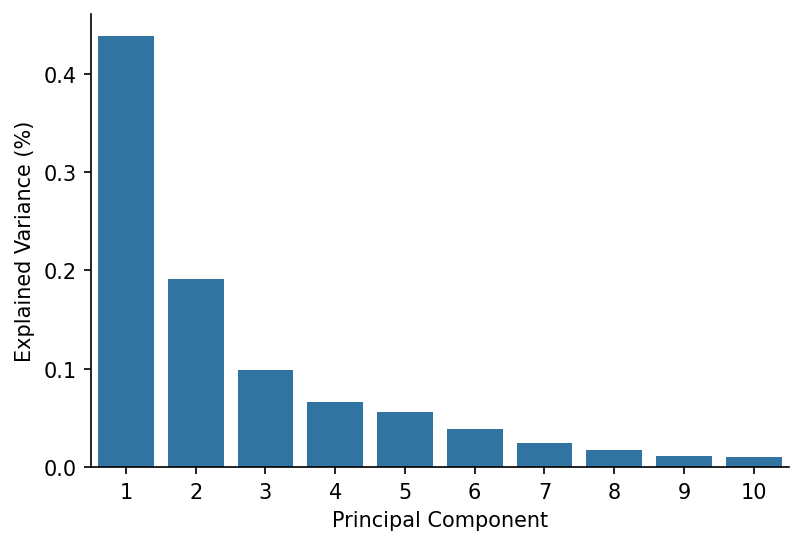

In [371]:
sns.barplot(x=np.arange(N_PCS) + 1, y=pca.explained_variance_ratio_, color=sns.color_palette()[0])
ax = plt.gca()
ax.set_ylabel("Explained Variance (%)")
ax.set_xlabel("Principal Component")
sns.despine()

print([f"{pc:.2f}%" for pc in pca.explained_variance_ratio_])
print([f"{pc:.2f}%" for pc in np.cumsum(pca.explained_variance_ratio_)])

## Track time

In [403]:
VISUALISE_PCS = 3   #
CALC_PCS = first_pcs.shape[-1]

In [404]:
# convert to an xarray dataset to keep an eye on time
s = config.test_start_date
e = config.test_end_date
test = dynamic.sel(station_id=int(station_id), time=slice(s, e))

times = test.time
time_deltas = sorted(pd.to_timedelta(np.arange(366), unit='d')[1:], reverse=True)

all_pcs = []
for ix in range(CALC_PCS):  # first_pcs.shape[-1]):
    pc = xr.Dataset(
        {f"pc{ix+1}": (["target_time", "time_delta"], np.squeeze(first_pcs[:, :, ix]))},
        coords={"target_time": times.values, "time_delta": time_deltas}
    )
    all_pcs.append(pc)
    
pcs = xr.merge(all_pcs)

In [405]:
time_vals = []
for ix in range(len(pcs.target_time.values)):
    time_vals.append(pcs.target_time.values[ix] - pcs.time_delta.values)
    
time_vals = np.array(time_vals)

In [406]:
actual_time = time_vals.flatten()
target_time = np.tile(pcs.target_time.values, 365)

all_pc_dfs = []
for pc_ix in range(CALC_PCS):
    vals = np.squeeze(first_pcs[:, :, pc_ix]).flatten()
    
    pc_t = pd.DataFrame({f"pc{pc_ix+1}": vals, "actual_time": actual_time, "target_time":target_time})
    pc_t["doy"] = pc_t["actual_time"].dt.dayofyear
    all_pc_dfs.append(pc_t)

,pc10,actual_time,target_time,doy
0,-0.978995,1997-01-01,1998-01-01,1
1,-0.088495,1997-01-02,1998-01-02,2
2,0.087916,1997-01-03,1998-01-03,3
3,-0.076174,1997-01-04,1998-01-04,4
4,0.117425,1997-01-05,1998-01-05,5
...,...,...,...,...
1466565,-0.002287,2008-12-26,2008-12-27,361
1466566,0.027443,2008-12-27,2008-12-28,362
1466567,0.108696,2008-12-28,2008-12-29,363
1466568,0.417470,2008-12-29,2008-12-30,364


### Compare the Seasonality of normalised PC of C_n vs Seasonality of Q

In [407]:
scaler = StandardScaler()
obs_discharge = scaler.fit_transform(dynamic.sel(station_id=int(station_id), time=slice(s, e)).discharge_spec.values.reshape(-1, 1))
obs_q = pd.DataFrame({"time": times.values, "norm_discharge": obs_discharge.flatten()})
obs_q["doy"] = obs_q["time"].dt.dayofyear

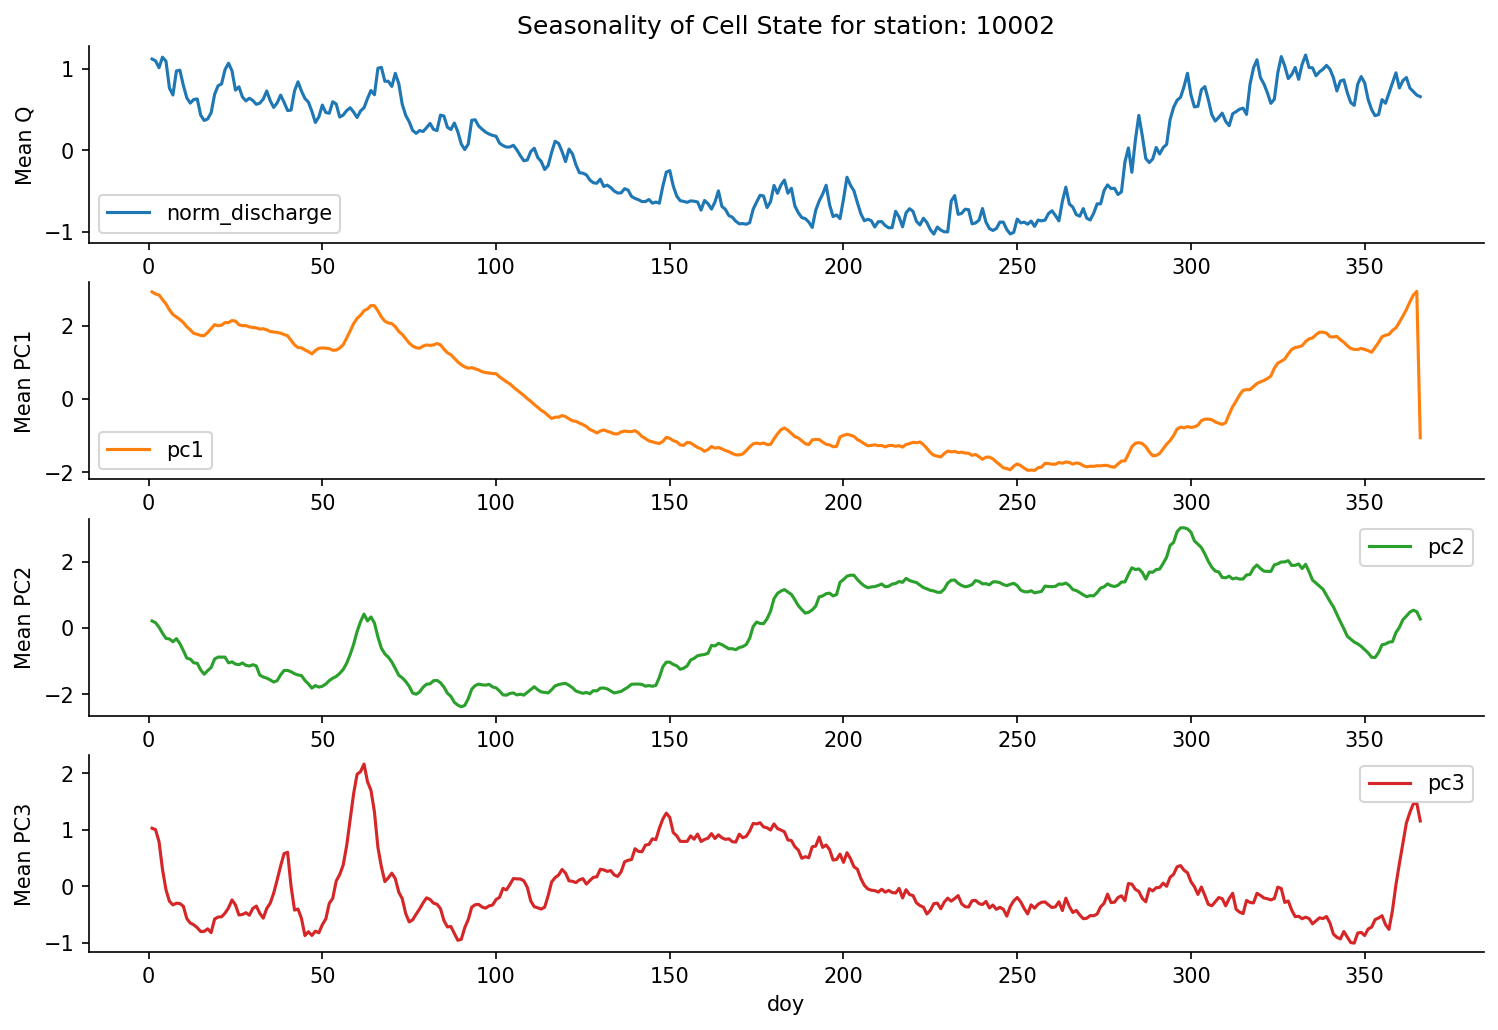

In [408]:
n_subplots = VISUALISE_PCS + 1

fig, axs = plt.subplots(n_subplots, 1, figsize=(12, 2*n_subplots))

axs[0].set_title(f"Seasonality of Cell State for station: {station_id}")
obs_q.groupby("doy").mean().plot(ax=axs[0], color=sns.color_palette()[0])

axs[0].set_ylabel("Mean Q")

# Plot the 
for pc_ix in range(VISUALISE_PCS):
    d = all_pc_dfs[pc_ix]
    d.groupby("doy").mean().plot(ax=axs[pc_ix + 1], color=sns.color_palette(None, 11)[pc_ix + 1])
    axs[pc_ix + 1].set_ylabel(f"Mean PC{pc_ix + 1}")

sns.despine()

# Compare to observed SM

In [409]:
obs_sm = pd.read_table(data_dir / "RUNOFF/Soil_Moisture_Catchments.csv", sep=";", decimal=",").drop("Unnamed: 0", axis=1)
obs_sm.head()

,Date,10002,10003,1001,101002,101005,102001,106001,107001,11001,...,9004,9005,92001,93001,94001,95001,96001,96002,96004,97002
0,2000-01-01,0.337877,0.381631,0.506113,NaN,NaN,0.397686,0.730406,NaN,0.353741,...,0.298484,0.306041,0.723135,0.716671,NaN,0.522572,0.725148,0.714350,0.476457,0.622826
1,2000-01-02,0.332717,0.377669,0.513014,NaN,NaN,0.388705,0.734120,NaN,0.353997,...,0.297326,0.307413,0.719752,0.709693,NaN,0.515382,0.733922,0.708342,0.473973,0.630514
2,2000-01-03,0.324421,0.370437,0.502599,NaN,NaN,0.402999,0.730592,NaN,0.349091,...,0.291302,0.300950,0.715811,0.711207,NaN,0.500618,0.718131,0.698553,0.459574,0.617390
3,2000-01-04,0.320845,0.366019,0.499462,NaN,NaN,0.404920,0.731137,NaN,0.341477,...,0.282174,0.288874,0.718646,0.693217,NaN,0.490456,0.714536,0.687420,0.449786,0.614374
4,2000-01-05,0.322252,0.369935,0.501533,NaN,NaN,0.397324,0.752046,NaN,0.352938,...,0.292348,0.303006,0.731672,0.713501,NaN,0.518180,0.722849,0.705080,0.469912,0.619883


In [254]:
sm_df = obs_sm.set_index("Date").stack().reset_index().rename({0: "soil_moisture", "level_1": "station_id", "Date": "time"}, axis=1)
sm_df["time"] = pd.to_datetime(sm_df["time"])
sm_df = sm_df.sort_values(["station_id", "time"]).set_index(["time", "station_id"])
sm = sm_df.to_xarray()
sm_df.head()

,,soil_moisture
time,station_id,
2000-01-01,10002,0.337877
2000-01-02,10002,0.332717
2000-01-03,10002,0.324421
2000-01-04,10002,0.320845
2000-01-05,10002,0.322252


In [252]:
# NORMALIZE SM
def normalize_dataframe_by_basin(df: pd.DataFrame):
    assert all(np.isin(["time", "station_id"], df.reset_index().columns))
    scaler = StandardScaler()
    norm_ = df.groupby("station_id").apply(lambda x: scaler.fit_transform(x).flatten())

    norm_df = norm_.explode().reset_index().rename({0: "norm"}, axis=1)
    norm_df["time"] = df.reset_index().sort_values(["station_id", "time"])["time"]
    norm_df = norm_df.set_index(["station_id", "time"])
    
    return  norm_df

In [255]:
norm_df = normalize_dataframe_by_basin(sm_df)
norm_df.head()

norm
station_id time                
10002      2000-01-01  0.576624
           2000-01-02  0.484179
           2000-01-03   0.33553
           2000-01-04  0.271458
           2000-01-05   0.29668

In [290]:
norm_sm = norm_df.to_xarray()
norm_climatology = norm_sm["norm"].groupby("time.dayofyear").mean(dim="time")

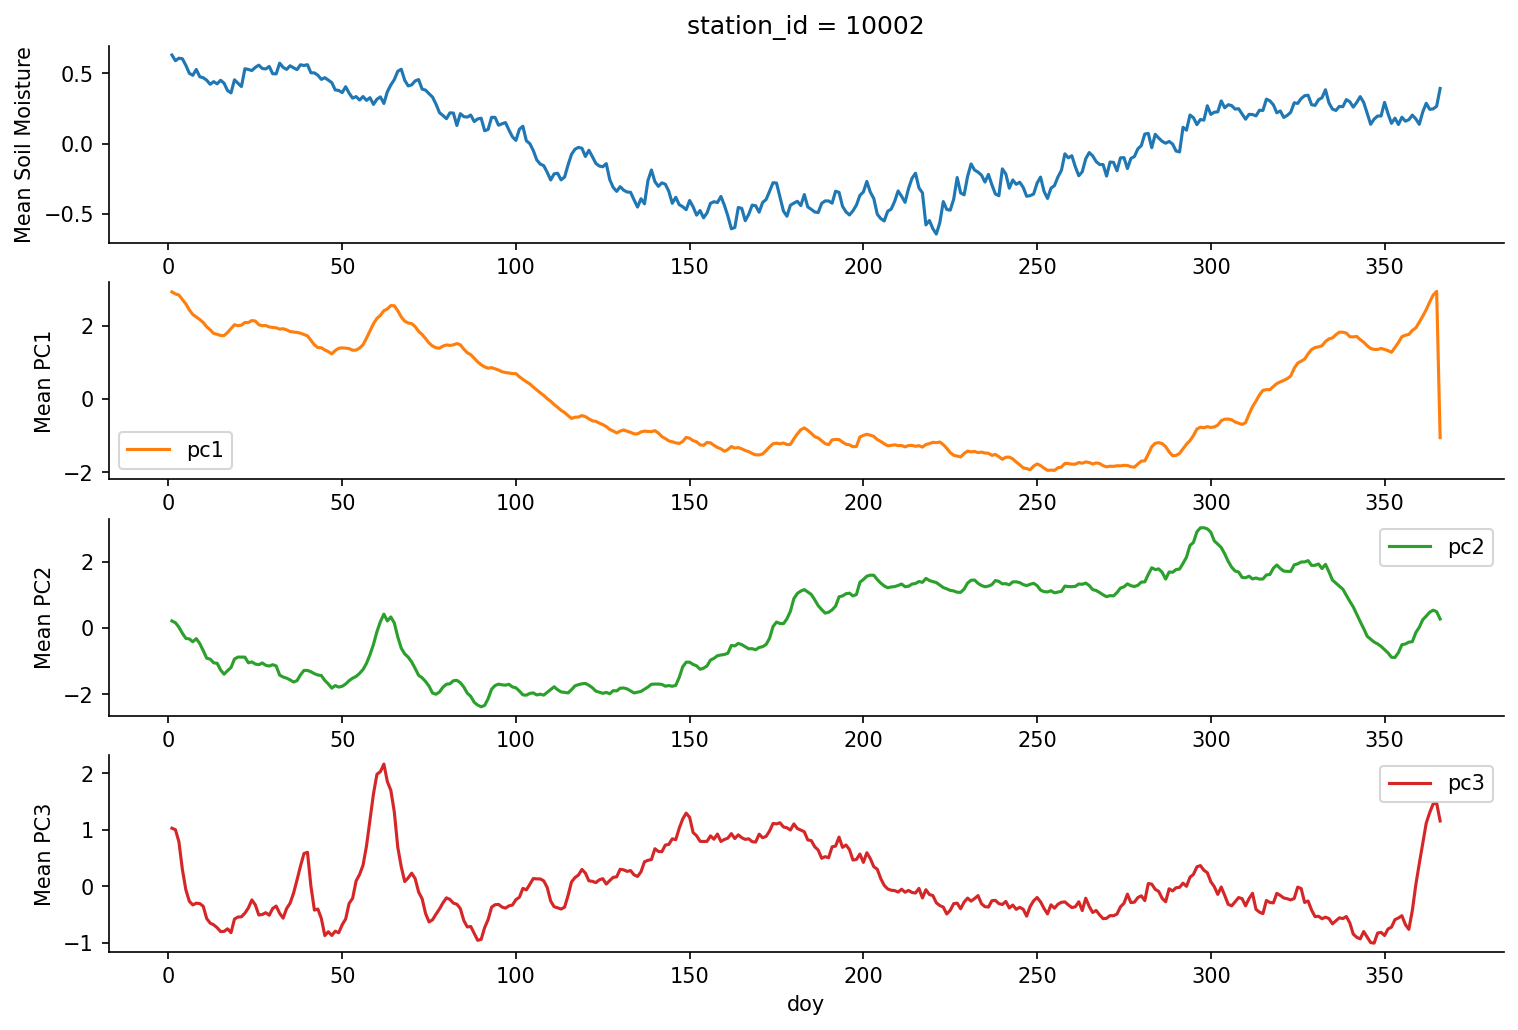

In [410]:
n_subplots = VISUALISE_PCS + 1
fig, axs = plt.subplots(n_subplots, 1, figsize=(12, 2*n_subplots))

axs[0].set_title(f"Seasonality of Cell State for station: {station_id}")
norm_climatology.sel(station_id=station_id).plot(ax=axs[0], color=sns.color_palette()[0], label="Soil Moisture")

axs[0].set_ylabel("Mean Soil Moisture")

# Plot the 
for pc_ix in range(VISUALISE_PCS):
    d = all_pc_dfs[pc_ix]
    d.groupby("doy").mean().plot(ax=axs[pc_ix + 1], color=sns.color_palette(None, n_colors=11)[pc_ix + 1])
    axs[pc_ix + 1].set_ylabel(f"Mean PC{pc_ix + 1}")

sns.despine()

In [357]:
eigenvectors = pca.components_
eigenvalues = pca.explained_variance_

In [365]:
# weights = 
eigenvalues[:3] / eigenvalues.sum()

array([0.4605183 , 0.20051323, 0.10313114], dtype=float32)

In [424]:
N_PCS = 3

sm_d = norm_climatology.sel(station_id=station_id)

# Plot the 
append_pcs = []
for pc_ix in range(N_PCS):
    d = all_pc_dfs[pc_ix]
    append_pcs.append(d.groupby("doy").mean())

pc_d = np.hstack(append_pcs)
pc_d.shape

(366, 3)

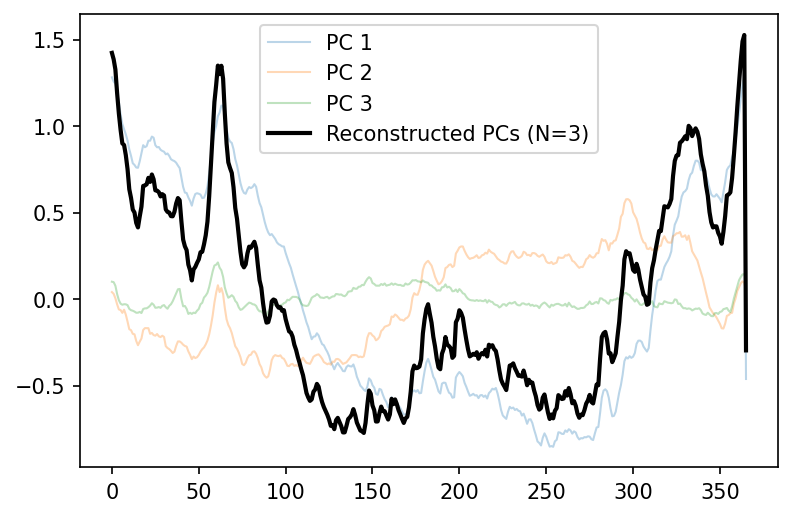

In [442]:
eigenvectors = pca.components_
eigenvalues = pca.explained_variance_
weights = pca.explained_variance_ratio_[:N_PCS]  # eigenvalues[:N_PCS] / eigenvalues.sum()

assert all((weights @ pc_d.T) == np.dot(weights, pc_d.T))

# obs_q.groupby("doy").mean().plot(label="Discharge", alpha=0.5, linewidth=1)
# sm_d.plot(label="Soil Moisture")
plt.plot(pc_d[:, 0] * weights[0], label="PC 1", linewidth=1, alpha=0.3)
plt.plot(pc_d[:, 1] * weights[1], label="PC 2", linewidth=1, alpha=0.3)
plt.plot(pc_d[:, 2] * weights[2], label="PC 3", linewidth=1, alpha=0.3)
plt.plot((weights @ pc_d.T), label=f"Reconstructed PCs (N={N_PCS})", linewidth=2, color='k')
plt.legend();

# Linear Regression

In [456]:
from torch import nn
from torch.utils.data import DataLoader
from typing import DefaultDict

In [ ]:
class CellStateLoader:
    def __init__(self, cs_data: xr.Dataset):
        self.basins = [k for k in all_basin_data.keys()]
        self.all_basin_data = all_basin_data
            
    def __len__(self):
        return len(self.basins)

    def __getitem__(self, item: int) -> Dict[str, torch.Tensor]:
        
        return sample

In [531]:
Y = 

<xarray.Dataset>
Dimensions:      (dimension: 64, station_id: 3, time: 1466570)
Coordinates:
  * time         (time) datetime64[ns] 1997-01-01 1997-01-02 ... 2008-12-30
  * dimension    (dimension) int64 0 1 2 3 4 5 6 7 8 ... 56 57 58 59 60 61 62 63
  * station_id   (station_id) <U5 '10002' '10003' '1001'
Data variables:
    cell_state   (time, dimension, station_id) float32 0.18249258 ... 18.074654
    target_time  (time) datetime64[ns] 1998-01-01 1998-01-02 ... 2008-12-31

In [506]:
cs_data

<xarray.Dataset>
Dimensions:      (dimension: 64, station_id: 3, target_time: 4018, time_delta: 365)
Coordinates:
  * target_time  (target_time) datetime64[ns] 1998-01-01 ... 2008-12-31
  * time_delta   (time_delta) timedelta64[ns] 365 days 364 days ... 1 days
  * dimension    (dimension) int64 0 1 2 3 4 5 6 7 8 ... 56 57 58 59 60 61 62 63
  * station_id   (station_id) <U5 '10002' '10003' '1001'
Data variables:
    cell_state   (target_time, time_delta, dimension, station_id) float32 0.18249258 ... 18.074654

In [ ]:
all_basin_data

In [ ]:
# for data in loader:
#     # train/update the weights
#     optimizer.zero_grad()
#     loss.backward()
#     optimizer.step()

#     losses.append(loss.detach().cpu().numpy())


In [472]:
basin_cs.shape

(4018, 365, 64)

<xarray.Dataset>
Dimensions:      (dimension: 64, station_id: 1, target_time: 4018, time_delta: 365)
Coordinates:
  * target_time  (target_time) datetime64[ns] 1998-01-01 ... 2008-12-31
  * time_delta   (time_delta) timedelta64[ns] 365 days 364 days ... 1 days
  * dimension    (dimension) int64 0 1 2 3 4 5 6 7 8 ... 56 57 58 59 60 61 62 63
  * station_id   (station_id) <U5 '10002'
Data variables:
    cell_state   (target_time, time_delta, dimension, station_id) float32 0.18249258 ... 20.461958

ValueError: Dimension station_id already exists.

In [482]:
basin_cs.shape
.shape

(4018, 365, 64, 1)